<a href="https://www.kaggle.com/theayushanand/2-pipeline-build-gan-relook?scriptVersionId=87470634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
from glob import glob
import numpy as np
from matplotlib import pylab as plt
import cv2
import time
import os
import torchvision.transforms as transforms
import torch
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import pandas as pd

2.6.2


In [3]:
df = pd.read_csv('../input/videopaths/datapaths.csv',header=0,index_col='Unnamed: 0')
df.replace('audio-files-for-miraclvc1/ph1-13','audio-files-for-miraclvc1/ph1-1',inplace=True)
for i in list(set(df['spectrograms'])):
    if not os.path.exists('../input/'+i+'.jpg'):
        df.replace(i,'audio-files-for-miraclvc1/ph1-1',inplace=True)

In [4]:
class Aud2LipsDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.imgs = df
    def __getitem__(self, idx):
        # load lipimage,spectrogram and target:lipmovement image
        lip_path = self.imgs['lippath'][idx]
        spect_path='../input/'+self.imgs['spectrograms'][idx]+'.jpg'
        lipmove_path=self.imgs['videopath'][idx]
        #resize and load as tensor
        lipimg=cv2.cvtColor(cv2.imread(lip_path), cv2.COLOR_BGR2RGB)
        spectimg=cv2.cvtColor(cv2.imread(spect_path),cv2.COLOR_BGR2RGB)
        lipmoveimg=cv2.cvtColor(cv2.imread(lipmove_path), cv2.COLOR_BGR2RGB)
        lipimg = lipimg[250:400,150:400]
        lipimg = cv2.resize(lipimg,(170,150))
        spectT = cv2.resize(spectimg,(80, 150))
        lipmoveimg=lipmoveimg[250:400,150:400]
        imageA = np.concatenate((lipimg,spectT),axis=1)
        imageB = lipmoveimg
        return imageA,imageB
    def __len__(self):
        return len(self.imgs)
dataset = Aud2LipsDataset()

In [5]:
def load_batch(batch_size):
    n_batches=int(len(df)/batch_size)
    for i in range(n_batches):
        img_A,img_B=[],[]
        for idx in range(i*batch_size,(i+1)*batch_size):
            img1,img2 = dataset[idx]
            img_A.append(img1)#picture
            img_B.append(img2)#label
      
        img_A=np.array(img_A)/127.5-1
        img_B=np.array(img_B)/127.5-1
    
        yield img_A,img_B #return generator

In [31]:
class pix2pix():
    def __init__(self):
        self.img_rows= 150
        self.img_cols= 250
        self.channels=3
        self.img_shape=(self.img_rows,self.img_cols,self.channels)
    
        patch=int(self.img_rows/(2**4)) # 16
        self.disc_patch=(10,16,1)
    
        self.gf=64
        self.df=64
    
        optimizerD = tf.keras.optimizers.Adam(0.0004,0.5)
        optimizerG = tf.keras.optimizers.Adam(0.0001,0.5)
        
        self.discriminator=self.build_discriminator()
        #self.discriminator.summary()
        self.discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizerD)
    
        self.generator=self.build_generator()
        #self.generator.summary()
    
        img_A=layers.Input(shape=self.img_shape)#picture--label
        img_B=layers.Input(shape=self.img_shape)#label--real
    
        img=self.generator(img_A)
    
        self.discriminator.trainable=False
    
        valid=self.discriminator([img,img_A])
    
        self.combined=Model(img_A,valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=optimizerG)
    
    def build_generator(self):
        def conv2d(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        def deconv2d(layer_input,skip_input,filters,f_size=(4,4),dropout_rate=0):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters,kernel_size=f_size,strides=(1,1),padding='same',activation='relu')(u)
            if dropout_rate:
                u=layers.Dropout(dropout_rate)(u)
            u=layers.BatchNormalization()(u)
            u=layers.Concatenate()([u,skip_input])
            return u
    
        d0=layers.Input(shape=self.img_shape)
    
        d1=conv2d(d0,self.gf,bn=False) 
        d1 = tf.keras.layers.Resizing(256,320)(d1)
        d2=conv2d(d1,self.gf*2)
        d2 = tf.keras.layers.Resizing(128,160)(d2)
        d3=conv2d(d2,self.gf*4)  
        d3 = tf.keras.layers.Resizing(64,80)(d3)
        d4=conv2d(d3,self.gf*8) 
        d4 = tf.keras.layers.Resizing(32,40)(d4)
        d5=conv2d(d4,self.gf*8)
        d5 = tf.keras.layers.Resizing(16,20)(d5)
        d6=conv2d(d5,self.gf*8)        
    
        d7=conv2d(d6,self.gf*8)         
    
        u1=deconv2d(d7,d6,self.gf*8,dropout_rate=0.5)
        u2=deconv2d(u1,d5,self.gf*8,dropout_rate=0.5)   
        u3=deconv2d(u2,d4,self.gf*8,dropout_rate=0.5)   
        u4=deconv2d(u3,d3,self.gf*4)   
        u5=deconv2d(u4,d2,self.gf*2)   
        u6=deconv2d(u5,d1,self.gf)     
        u7=layers.UpSampling2D((2,2))(u6)
    
        output_img=layers.Conv2D(self.channels,kernel_size=(4,4),strides=(1,1),padding='same',activation='tanh')(u7)
        output_img = tf.keras.layers.Resizing(150,250)(output_img)
        
        return Model(d0,output_img)
  
    def build_discriminator(self):
        def d_layer(layer_input,filters,f_size=(4,4),bn=True):
            d=layers.Conv2D(filters,kernel_size=f_size,strides=(2,2),padding='same')(layer_input)
            d=layers.LeakyReLU(0.2)(d)
            if bn:
                d=layers.BatchNormalization()(d)
            return d
    
        img_A=layers.Input(shape=self.img_shape)
        img_B=layers.Input(shape=self.img_shape)
    
        combined_imgs=layers.Concatenate(axis=-1)([img_A,img_B])
    
        d1=d_layer(combined_imgs,self.df,bn=False)
        d2=d_layer(d1,self.df*2)
        d3=d_layer(d2,self.df*4)
        d4=d_layer(d3,self.df*8)
    
        validity=layers.Conv2D(1,kernel_size=(4,4),strides=(1,1),padding='same',activation='sigmoid')(d4)
    
        return Model([img_A,img_B],validity)
  
    def train(self,epochs,batch_size=1):
        valid=np.ones((batch_size,)+self.disc_patch)
        fake=np.zeros((batch_size,)+self.disc_patch)
    
        for epoch in range(epochs):
            start=time.time()
            for batch_i,(img_A,img_B) in enumerate(load_batch(batch_size)):
                gen_imgs=self.generator.predict(img_A)
        
                d_loss_real = self.discriminator.train_on_batch([img_B, img_A], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, img_A], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
                g_loss = self.combined.train_on_batch(img_A,valid)
                g_loss = self.combined.train_on_batch(img_A,valid)

                if batch_i % 50 == 0:
                    print ("[Epoch %d] [Batch %d] [D loss: %f] [G loss: %f]" % (epoch,
                                                                                batch_i,
                                                                                d_loss,
                                                                                g_loss))
                if batch_i % 1000 == 0:
                    tf.keras.models.save_model(self.generator, 'trained-gan-model',
                                               overwrite=True, include_optimizer=True,
                                               save_format=None)
            self.sample_images(epoch)
            print('Time for epoch {} is {} sec'.format(epoch,time.time()-start))
      
    def sample_images(self, epoch):
        (o,t) = dataset[3180]
        o=o[None,]
        outi_image = gan.generator.predict(o)
        plt.imshow(outi_image.squeeze())
        plt.savefig("./%d.png" % (epoch))
        plt.show()

## Loading Model

In [32]:
if __name__ == '__main__':
    gan = pix2pix()
    gan.generator = tf.keras.models.load_model('../input/gan-aud2lips-v2/trained-gan-model/', compile=True)
    gan.train(1,4)

[Epoch 0] [Batch 0] [D loss: 1.953321] [G loss: 0.654430]


2022-02-10 11:27:20.349113: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[Epoch 0] [Batch 50] [D loss: 0.004473] [G loss: 0.202539]


KeyboardInterrupt: 

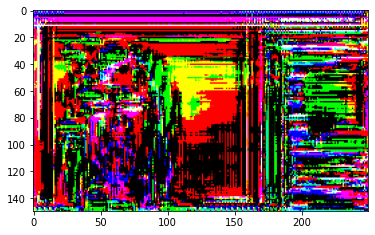

In [37]:
(o,t) = dataset[0]
o=o[None,]
out_image = gan.generator.predict(o)
plt.imshow(out_image.squeeze())